# <center> Deep Learning Project:

> - __Ahmed Abdelazeem__ (m20210433)
> - __Omar Jarir__ (m20201378)  
> - __Chung-Ting Huang__ (m20210437) 

- The objective of this project is to forecast the evolutions of "bitcoin" prices, by using reccurent neural networks.
such as RNN and LSTM.
- The project is organized as follows:

In [1]:
# !pip install keras-tuner --upgrade
# !pip install -q -U keras-tuner

In [2]:
import time
t1 = time.perf_counter()

- __Importing the necessary libraries 📚:__

In [3]:
import os
from zipfile import ZipFile
import numpy as np
import random as python_random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
import tensorflow as tf
from tensorflow import keras 
import keras_tuner as kt

In [4]:
from keras.models import Model, Sequential
from keras.layers import Dense, BatchNormalization, LSTM, Embedding, Input, Dropout, SimpleRNN, RNN, Bidirectional
#from keras.Optimizer import Adam, SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl, schedules
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, History, ReduceLROnPlateau 
#from keras.utils import plot_model
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor 
import keras.backend as K

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import class_weight

from pprint import pprint

In [5]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import category_encoders as ce
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.classifier import ClassificationReport

import scikitplot as skplt
import xgboost

from mlxtend.evaluate import mcnemar
from mlxtend.evaluate import mcnemar_table

from imblearn.over_sampling import SMOTE

from yellowbrick.model_selection import RFECV
from yellowbrick.model_selection import LearningCurve

from sklearn.ensemble import RandomForestClassifier

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
SEED = 2022

LEARNING_RATE = 0.001
BATCH_SIZE = 256
EPOCHS = 10
time_steps=5

Fixing the random number seed to ensure our results are reproducible.

In [8]:
session = K.get_session()
# init_op = tf.group(tf.tables_initializer(),tf.global_variables_initializer(),
# tf.local_variables_initializer())
#session.run(init_op)

np.random.seed(SEED)
tf.random.set_seed(SEED)
python_random.seed(SEED)

- __Helper functions:__

In [9]:
# Function to create dataframe with metrics

def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
    measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
    train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain, average='weighted'),
                metricsObj.f1_score(yTrain, yPredTrain, average='weighted'),
                metricsObj.roc_auc_score(yTrain, yPredTrain),    
                ]
    test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest, average='weighted'),
               metricsObj.f1_score(yTest, yPredTest, average='weighted'),
               metricsObj.roc_auc_score(yTest, yPredTest), 
               ]
    resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
    return(resultsDF)

In [10]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [11]:
# Function to find outliers on columns based on percentile
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

In [12]:
def create_model(nl=1, nn=256):
    model = Sequential()
    model.add(Dense(16, input_shape=(2,), activation="relu"))
    # Add as many hidden layers as specified in nl
    for i in range(nl):
        # Layers have nn neurons
        model.add(Dense(nn, activation='relu'))
    # End defining and compiling your model...

In [13]:
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()
    plt.show()

In [14]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.tight_layout()
    plt.show()


In [15]:
# This function plot the "loss" and the "val_loss" variables.
def visualize_loss(history, title):
    """
    history: history of the model.
    title: Title of the plot.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, "g", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [16]:
# This function plot the "accuracy" and the "val_accuracy" variables.
def visualize_accuracy(history, title):
    """
    history: history of the model.
    title: Title of the plot.
    """
    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, "g", label="Training accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation accuracy")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [17]:
# This function plot the "error" and the "val_error" variables.
def visualize_error(history, title):
    """
    history: history of the model.
    title: Title of the plot.
    """
    error = history.history["mae"]
    val_error = history.history["val_mae"]
    epochs = range(len(error))
    plt.figure(figsize=(10, 10))
    plt.plot(epochs, error, "b", label="Training error")
    plt.plot(epochs, val_error, "r", label="Validation error")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [18]:
def show_plot(plot_data, delta, title):
    """
    plot_data:
    delta:
    title:
    """
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.tight_layout()
    plt.show()
    return

In [19]:
def plot_predictions(val, predicted, title, date):
    plt.figure(figsize=(16,4))
    plt.plot(date, val, color='blue',label='Actual') # date, 
    plt.plot(date,predicted, alpha=0.7, color='red',label='Predict') # date, 
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Something')
    plt.legend()
    plt.tight_layout()
    plt.show()

- __Loading the dataset:__

In [20]:
#import requests as rq
#from io import BytesIO

#url = "https://raw.githubusercontent.com/omarja12/DS_Project2/main/default_credit_card_clients.xlsx"
#data = rq.get(url).content
#ds = pd.read_excel(BytesIO(data), engine='openpyxl')

In [21]:
ds= pd.read_csv("data.csv")

In [22]:
ds.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [23]:
ds.shape

(6819, 96)

In [24]:
# This variable is to be dropped.
ds["Bankrupt?"].unique()

array([1, 0], dtype=int64)

In [25]:
# Initialize model
rf_model = RandomForestClassifier(n_estimators=10, random_state=SEED)

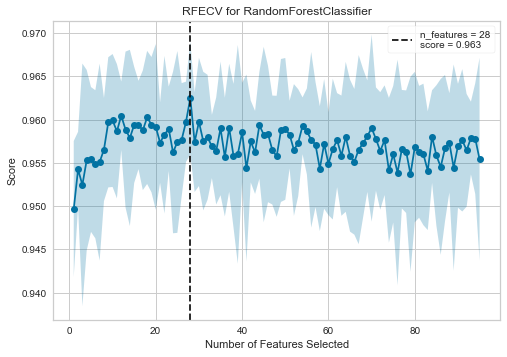

In [ ]:
%%timeit

# I get to select 17 features.

# Applying RFECV (Recursive Feature Elimination) to select features
# see https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html
cv = StratifiedKFold(3)
vis = RFECV(rf_model, scoring='f1_weighted') ## , cv=cv
vis.fit(ds.drop(columns="Bankrupt?"), ds["Bankrupt?"])
vis.show()

In [ ]:
vis.ranking_

In [ ]:
# Features to include: 
ds.columns[vis.support_]

In [ ]:
ds

In [ ]:
# Plot the learning curve

# I DONT NEED LEARNING CURVE NOW, THIS SHOULD BE DONE ON THE NEXT PARTS.

#cv = 3
#sizes = np.linspace(0.1, 1.0, 5)
#visualizer = LearningCurve(estimator=rf_model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4, random_state=SEED)
#visualizer.fit(ds.drop(columns="Bankrupt?"), ds["Bankrupt?"])
#visualizer.show()     

In [ ]:
# Checking that the target distribution is imbalanced.

sns.countplot(y='Bankrupt?', data = ds, palette='viridis', orient = 'h')

In [ ]:
# Setting the first line to be the columns name.

ds.columns = ds.iloc[0]
ds = ds.drop(labels=0, axis=0)

# Data Exploration:

In [ ]:
ds.head()

In [ ]:
# We can see that our dataset does not contain any duplicates.

ds.duplicated().sum()

In [ ]:
# Dropping the 'ID' column as it does not provide any informations.
ds.drop(columns=['ID'], inplace=True)

In [ ]:
# Checking the type of the columns
ds.dtypes

In [ ]:
ds = ds.astype(float)

In [ ]:
ds.columns

# Data Pre-processing:

In [ ]:
# Renaming the columns 'PAY_0' to 'PAY_1', and 'default payment next month' to 'TARGET'.

ds = ds.rename(columns={'PAY_0': 'PAY_1', 'default payment next month': 'TARGET'})

In [ ]:
# The variables 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6' and the target 
# 'default payment next month' should be integers.

lst=['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
     'TARGET']

ds[lst]=ds[lst].astype(int)

In [ ]:
ds.describe().T

In [ ]:
# We try to apply the log transformation to a group of variables, 
# in order to check if the distributions are less skewed. 

Bill_Amt=['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

ds['Log_PAY_AMT1'] = np.log1p(ds['PAY_AMT1'])
ds['Log_PAY_AMT2'] = np.log1p(ds['PAY_AMT2'])
ds['Log_PAY_AMT3'] = np.log1p(ds['PAY_AMT3'])
ds['Log_PAY_AMT4'] = np.log1p(ds['PAY_AMT4'])
ds['Log_PAY_AMT5'] = np.log1p(ds['PAY_AMT5'])
ds['Log_PAY_AMT6'] = np.log1p(ds['PAY_AMT6'])

In [ ]:
# A new variable is created based on the mean of the features for each observation.

ds['BILL_AMT']= ds[Bill_Amt].mean(axis=1) 

In [ ]:
# Dropping the unnecessary columns:

ds.drop(columns= ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
                  'BILL_AMT5', 'BILL_AMT6'], inplace=True)
ds.drop(columns= ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 
                  'PAY_AMT5', 'PAY_AMT6'], inplace=True)

In [ ]:
# Create a modeling dataset from the original dataset
X = ds.copy(deep=True)

In [ ]:
cols=['LIMIT_BAL', 'AGE', 'BILL_AMT',
      'Log_PAY_AMT1', 'Log_PAY_AMT2', 'Log_PAY_AMT3', 'Log_PAY_AMT4', 'Log_PAY_AMT5', 'Log_PAY_AMT6']

## Dealing with outliers:

In [ ]:
X = removeOutliers(X, colList=cols , lowPercentile=0.05, highPercentile=0.95, verbose=True) 

In [ ]:
# Transforming a list of columns to categorical.

cols = ['SEX', 'EDUCATION', 'MARRIAGE']
ds[cols] = ds[cols].apply(lambda x:x.astype('category'))

## One Hot encoding the categorical features:

In [ ]:
# Encode categorical values into dummy variables.

cols = ['SEX', 'EDUCATION', 'MARRIAGE']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [ ]:
y = X['TARGET']
X = X.drop(columns=['TARGET'])

## Splitting the dataset:

In [ ]:
# Split the dataset intro train and test sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                   shuffle =True, stratify=y, random_state=SEED)

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

## Data Normalization:

In [ ]:
# We use the standard scaler in order to normalize the data

sc = StandardScaler() 
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test)

# Modelling:

## First Model:

In [ ]:
METRICS = [
    FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'),
    Precision(name='precision'), Recall(name='recall'), AUC(name='auc'),]

In [ ]:
# Building the first model

def create_model(nn=16, nl=1, learning_rate=0.001, activation="relu", optim="adam", 
                 init="glorot_uniform"):
    classifier = Sequential()
    # Let's add the first hidden layers
    classifier.add(Dense(units=nn, kernel_initializer=init, activation=activation,
                         input_dim=X_train.shape[1])) 
    # input_shape?
    for _ in range(nl):
        classifier.add(Dense(units=8, kernel_initializer=init, activation=activation))
        classifier.add(Dense(units=4, kernel_initializer=init, activation=activation))
        classifier.add(Dense(units=1, kernel_initializer=init, activation="sigmoid"))
    
    classifier.compile(optimizer=optim, loss="binary_crossentropy", metrics=["accuracy"])
    return classifier

Using Keras Tuner:

In [ ]:
# I SHOULD GET INSPIRED BY THIS TO BUILD TO DO HYPER TUNNING

def get_model_design_hp(hp):
    model = Sequential([Conv2D(hp.Int('filters_0',16,32,step=8,default=32),kernel_size=(5,5),padding='same',kernel_regularizer=l2(0.001),activation='relu',input_shape=INPUT_SHAPE),
                        Conv2D(hp.Int('filters_1',16,32,step=8,default=16),kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001),activation='relu'),
                        MaxPool2D(pool_size=(2,2)),
                        BatchNormalization(),
                        Flatten(),
                        Dropout(hp.Float('dropout',0,0.5,step=0.25,default=0.5)),
                        Dense(units = hp.Int('Dense',32,64,step=8,default=64),activation='relu'),
                        Dropout(0.2),
                        Dense(1, kernel_initializer=GlorotNormal(), activation='sigmoid')
                       ])
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                loss='binary_crossentropy',metrics= METRICS) 
    
    return model

In [ ]:
import kerastuner as kt

tuner = kt.Hyperband(
    get_model_design_hp,
    objective= 'val_loss' ,#'val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory = LOG_DIR    
)

In [ ]:
tuner.search(train_generator,
             validation_data = validation_generator,
             epochs=2,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

In [ ]:
best_model = tuner.get_best_models(1)[0]

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/

In [ ]:
# How can i use this?

keras_classifier = KerasClassifier(build_fn=create_model, epochs=50, batch_size=256, verbose=1)

In [ ]:
# create model
# evaluate using 10-fold cross validation

#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
#results = cross_val_score(keras_classifier, X_train, y_train, cv=kfold)
#print(results.mean())
#print(results.std())

In [ ]:
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]

param_grid = dict(optim=optimizers, epochs=epochs, batch_size=batches, init=init)

random_search = RandomizedSearchCV(estimator=keras_classifier, param_distributions=param_grid)

random_search_results = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (random_search_results.best_score_, random_search_results.best_params_))
means = random_search_results.cv_results_['mean_test_score']
stds = random_search_results.cv_results_['std_test_score']
params = random_search_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Print results
print("Best: %f using %s".format(random_search_results.best_score_, random_search_results.best_params_))

In [ ]:
classifier = create_model(nn=16)

In [ ]:
classifier.summary()

In [ ]:
# Path + name of the file we wanna create.
path_checkpoint = "model_checkpoint.h5"

early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="auto")

model_save = ModelCheckpoint(monitor="val_loss", filepath=path_checkpoint, verbose=1, 
                             save_best_only=True)

Hist = History()

In [ ]:
class_weights=dict(enumerate(class_weight.compute_class_weight('balanced', 
                            classes=np.unique(y_train), y=y_train)))

In [ ]:
hist = classifier.fit(X_train, y_train,  
                      batch_size=64,
                      validation_split=0.2,
                      epochs=1000,
                      callbacks = [early_stopping, model_save, Hist],  
                      #class_weight=class_weights
                     )

In [ ]:
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

In [ ]:
y_pred_train=(y_pred_train>0.5).astype(int)
y_pred_test=(y_pred_test>0.5).astype(int)

In [ ]:
# Show the confusion matrix
cm = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

In [ ]:
print('Classification Report')

target_names=["No Default", "Default"]
print(classification_report(y_test, y_pred_test, target_names=target_names))

In [ ]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, 
                                 y_test, y_pred_test)
resultsDF

In [ ]:
visualize_loss(hist, "Training and validation loss")

In [ ]:
visualize_accuracy(hist, "Training and validation accuracy")

## Using class_weight:

## Using a Focal Loss:

https://github.com/umbertogriffo/focal-loss-keras

In [ ]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

## Using S.M.O.T.E:

In [ ]:
# S.M.O.T.E

sm = SMOTE(k_neighbors=10, random_state=SEED)
X_train, y_train = sm.fit_resample(X_train, y_train)

- This part is inspired from:
https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/

An LSTM is a neural network, which sequentially loops after each observation. This means that the observations are equipped with a forgetting structure, similar to exponential smoothing. 

We have to reshape the dataset into the structure [samples, timesteps, features].

In [ ]:
t2 = time.perf_counter()
print('time taken to run:',(t2-t1)/60.0)